In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from implied_vol import *
from finite_diff_methods import *

In [2]:
call = pd.read_pickle("./datasets/call.pkl")
put = pd.read_pickle("./datasets/put.pkl")
equity_data = pd.read_pickle("./datasets/equity.pkl")

In [3]:
# clean
expiry = ['2021-04-16', '2021-05-21', '2021-06-18']
def clean(data):
    new_data = []
    for df,date in zip(data, expiry):
        df['expiry'] = pd.to_datetime(date)
        df['t2m'] = (df['expiry'] - pd.Timestamp('today')) / np.timedelta64(1, 'Y')
        df['s0'] = equity_data.iloc[0,3]
        df['market_price'] = df.bid/2 + df.ask/2
        # choose by volume
        df = df.sort_values(by='volume', ascending=False)
        new_df = df.iloc[0:10].reset_index()
        del new_df['index']
        new_data.append(new_df)
    return new_data
call = clean(call)
put = clean(put)

In [4]:
# get vol
r = 0.07/100
for df in call:
    df['type'] = 'c'
    df['vol'] = df.apply(lambda x:
                         get_impliedVol('c', x.s0, x.strike, x.t2m, r, x.market_price),axis=1)

for df in put:
    df['type'] = 'p'
    df['vol'] = df.apply(lambda x:
                         get_impliedVol('p', x.s0, x.strike, x.t2m, r, x.market_price),axis=1)

In [5]:
epsilon = 0.0005

In [6]:
def fd_price(x, epsilon, method):
    dt = epsilon / (3 * x.vol ** 2 + 1)
    dx = x.vol * np.sqrt(3 * dt)
    N = int(np.ceil(x.t2m / dt))
    Nj = int(np.ceil((2 * np.sqrt(3 * N) - 1) / 2))
    return method(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type, 'e')

In [7]:
for df1,df2 in zip(call, put):
    df1['EFD'] = df1.apply(lambda x: 
                           fd_price(x, epsilon, e_fdm),axis=1)
    df1['IFD'] = df1.apply(lambda x:
                           fd_price(x, epsilon, i_fdm),axis=1)
    df1['CNFD'] = df1.apply(lambda x:
                            fd_price(x, epsilon, cn_fdm),axis=1)
    df2['EFD'] = df2.apply(lambda x:
                           fd_price(x, epsilon, e_fdm),axis=1)
    df2['IFD'] = df2.apply(lambda x:
                           fd_price(x, epsilon, i_fdm),axis=1)
    df2['CNFD'] = df2.apply(lambda x:
                            fd_price(x, epsilon, cn_fdm),axis=1)

In [12]:
def get_greeks(x):
    dt = epsilon / (3 * x.vol ** 2 + 1)
    dx = x.vol * np.sqrt(3 * dt)
    N = int(np.ceil(x.t2m / dt))
    Nj = int(np.ceil((2 * np.sqrt(3 * N) - 1) / 2))
    delta,gamma,theta = delta_gamma_theta(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type)
    vega_ = vega(x.s0, x.strike, x.t2m, r, x.vol, 0, N, Nj, dx, x.type)
    return delta, gamma, vega_, theta

In [13]:
for df1,df2 in zip(call, put):
    df1[['delta', 'gamma', 'vega', 'theta']] = \
    df1.apply(get_greeks,axis=1, result_type="expand")
    df2[['delta', 'gamma', 'vega', 'theta']] = \
    df2.apply(get_greeks,axis=1, result_type="expand")

In [14]:
# save to csv
for df1,df2 in zip(call, put):
    path1 = './p2_csv/' + df1.iloc[0,0][0:10] + '.csv'
    path2 = './p2_csv/' + df2.iloc[0,0][0:10] + '.csv'
    df1.to_csv(path1, index=False)
    df2.to_csv(path2, index=False)

In [16]:
call[1]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,...,market_price,type,vol,EFD,IFD,CNFD,delta,gamma,vega,theta
0,SPY210521C00395000,2021-03-19 17:59:04,395.0,9.10,9.08,9.12,-0.280000,-2.985072,2821.0,19068,...,9.10,c,0.173769,9.102960,9.095507,9.099235,0.455085,0.014394,62.927861,-33.362440
1,SPY210521C00397000,2021-03-19 16:03:52,397.0,7.73,7.94,7.98,-0.750000,-8.844335,2074.0,3558,...,7.96,c,0.168710,7.963594,7.956648,7.960122,0.423854,0.014646,62.378401,-31.994756
2,SPY210521C00435000,2021-03-19 17:15:43,435.0,0.37,0.38,0.40,-0.060000,-13.953488,1831.0,6551,...,0.39,c,0.149597,0.389277,0.392482,0.390881,0.041666,0.003753,21.315065,-6.407610
3,SPY210521C00400000,2021-03-19 17:57:30,400.0,6.52,6.54,6.58,-0.430000,-6.187048,1663.0,0,...,6.56,c,0.164194,6.560108,6.553994,6.557052,0.377401,0.014603,61.017854,-30.207834
4,SPY210521C00424000,2021-03-19 16:33:56,424.0,0.95,0.97,0.99,-0.150000,-13.636367,1552.0,629,...,0.98,c,0.147813,0.980917,0.983280,0.982098,0.092524,0.007066,33.305611,-11.803056
5,SPY210521C00390000,2021-03-19 17:56:57,390.0,12.01,11.96,12.00,-0.469999,-3.766020,1509.0,10313,...,11.98,c,0.182748,11.982406,11.974444,11.978427,0.527138,0.013744,63.039439,-35.243587
6,SPY210521C00396000,2021-03-19 17:55:27,396.0,8.57,8.52,8.56,-0.380000,-4.245812,1327.0,3303,...,8.54,c,0.171528,8.534841,8.527606,8.531225,0.439713,0.014518,62.733326,-32.785333
7,SPY210521C00430000,2021-03-19 17:38:07,430.0,0.57,0.58,0.60,-0.080000,-12.307690,1253.0,13491,...,0.59,c,0.148314,0.589593,0.592653,0.591124,0.060005,0.005062,26.252506,-8.502801
8,SPY210521C00405000,2021-03-19 17:53:09,405.0,4.66,4.52,4.56,-0.170000,-3.519671,1230.0,10840,...,4.54,c,0.156456,4.536596,4.532431,4.534512,0.299120,0.014009,57.122995,-26.297923
9,SPY210521C00404000,2021-03-19 17:53:23,404.0,5.00,4.87,4.91,-0.140000,-2.723733,1013.0,0,...,4.89,c,0.157636,4.892657,4.888082,4.890368,0.314381,0.014204,58.020989,-27.069662


In [28]:
info = ['t2m', 'strike', 'type', 'ask', 'bid',
       'market_price', 'vol', 'EFD', 'IFD', 'CNFD']
data1 = call[1][info].round(4)
data2 = put[1][info].round(4)
data1 = data1.sort_values(by='market_price', ascending=False)
data2 = data2.sort_values(by='market_price', ascending=False)
data1.to_csv('./p2_csv/d_res1.csv', index=False)
data2.to_csv('./p2_csv/d_res2.csv', index=False)

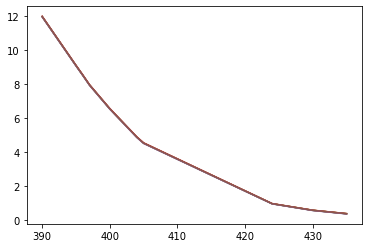

In [35]:
plt.plot(data1.strike, data1.EFD)
plt.plot(data1.strike, data1.IFD)
plt.plot(data1.strike, data1.CNFD)
plt.plot(data1.strike, data1.ask)
plt.plot(data1.strike, data1.bid)
plt.plot(data1.strike, data1.market_price)

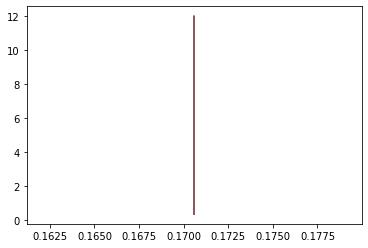